## GCM-Filters

gcm-filters (https://gcm-filters.readthedocs.io/) uses a laplacian-based method to smooth any field. The method is complementary to corase-granning. For a comparison purpose, we use gcm-filters to compute barotropic vorticity diagnostics at 100-2000 km resolution.

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import regionmask
import gcm_filters
import matplotlib.pyplot as plt

from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

In [77]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', aspect_rt = 1.0):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    #cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    #cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    #ax.coastlines()
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator(np.arange(-80,81,20))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(aspect_rt)
    
    _ = plt.title(title, fontsize=14)
    return p

In [2]:
ds_vort = xr.open_dataset("../../Data/OM4p25_JRA55_Vorticity_Budget_1958_2017_Mean.nc")

var_list = ['beta_V', 'BPT', 'Curl_Adv', 'Curl_taus', 'Curl_taub', 
            'Curl_diff', 'Mass_flux', 'Curl_dudt', 'eta_dt']

ds2 = ds_vort.get(var_list).astype(np.float64)
wet_mask = ds_vort['wet_c'].astype(np.float64)
area = ds_vort['areacello_bu'].astype(np.float64)

print(ds2)

<xarray.Dataset>
Dimensions:    (yq: 1080, xq: 1440)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    beta_V     (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BPT        (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_Adv   (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taus  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taub  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_diff  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Mass_flux  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_dudt  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    eta_dt     (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan


In [3]:
# Let's count number of non-nan grid points in each field

for var in var_list:
    
    tmp = ds2[var]
    
    count_grid = xr.where(np.isnan(tmp), 0.0, 1.0)
    
    print(var, ": Grid points = ", count_grid.sum(['yq','xq']))
    
# since the numner of grid points are not consistent across variables. We need to assign nan to grid points 
# that are not common in variables
# Otherwise, filtered fields will not have a closed vorticity budget near sea-land boundaries.

beta_V : Grid points =  <xarray.DataArray 'beta_V' ()>
array(952747.)
BPT : Grid points =  <xarray.DataArray 'BPT' ()>
array(930170.)
Curl_Adv : Grid points =  <xarray.DataArray 'Curl_Adv' ()>
array(952747.)
Curl_taus : Grid points =  <xarray.DataArray 'Curl_taus' ()>
array(952747.)
Curl_taub : Grid points =  <xarray.DataArray 'Curl_taub' ()>
array(952747.)
Curl_diff : Grid points =  <xarray.DataArray 'Curl_diff' ()>
array(952747.)
Mass_flux : Grid points =  <xarray.DataArray 'Mass_flux' ()>
array(952768.)
Curl_dudt : Grid points =  <xarray.DataArray 'Curl_dudt' ()>
array(952747.)
eta_dt : Grid points =  <xarray.DataArray 'eta_dt' ()>
array(930170.)


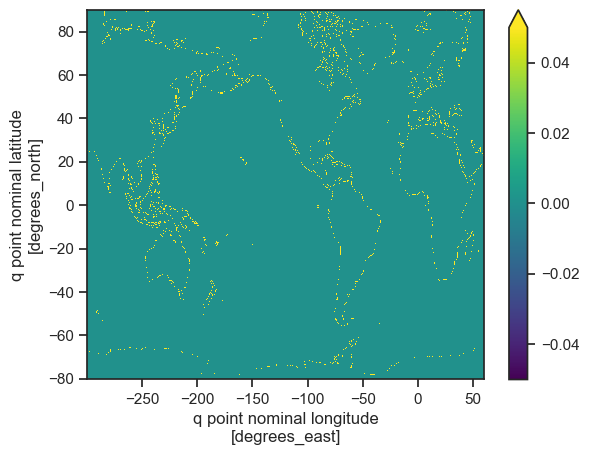

In [4]:
count_grid1 = xr.where(np.isnan(ds2['eta_dt']), 0.0, 1.0)
count_grid2 = xr.where(np.isnan(ds2['beta_V']), 0.0, 1.0)

(count_grid2 - count_grid1).plot(robust=True)

In [5]:
ds3 = ds2.copy()

for var in var_list:
    
    ds3[var] = xr.where(np.isnan(ds2['BPT']), np.nan, ds2[var]) # only keep grid points that have non-nan values for BPT
    
    count_grid = xr.where(np.isnan(ds3[var]), 0.0, 1.0)
    
    print(var, ": Grid points = ", count_grid.sum(['yq','xq']))
    
wet_mask = xr.where(np.isnan(ds2['BPT']), 0., wet_mask)

beta_V : Grid points =  <xarray.DataArray 'beta_V' ()>
array(930170.)
BPT : Grid points =  <xarray.DataArray 'BPT' ()>
array(930170.)
Curl_Adv : Grid points =  <xarray.DataArray 'Curl_Adv' ()>
array(930170.)
Curl_taus : Grid points =  <xarray.DataArray 'Curl_taus' ()>
array(930170.)
Curl_taub : Grid points =  <xarray.DataArray 'Curl_taub' ()>
array(930170.)
Curl_diff : Grid points =  <xarray.DataArray 'Curl_diff' ()>
array(930170.)
Mass_flux : Grid points =  <xarray.DataArray 'Mass_flux' ()>
array(930170.)
Curl_dudt : Grid points =  <xarray.DataArray 'Curl_dudt' ()>
array(930170.)
eta_dt : Grid points =  <xarray.DataArray 'eta_dt' ()>
array(930170.)


Mask Grid points =  <xarray.DataArray ()>
array(930170.)


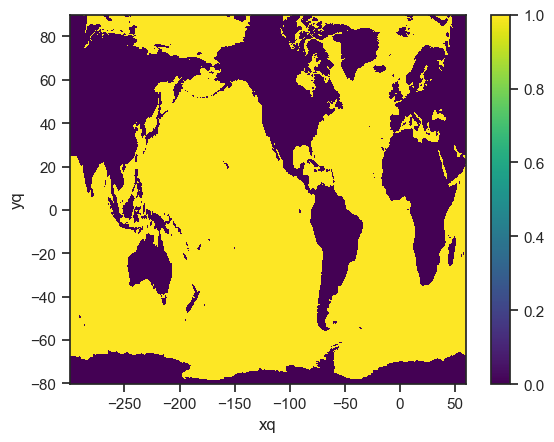

In [6]:
print("Mask Grid points = ", wet_mask.sum(['yq','xq']))

wet_mask.plot()

## Compute filtered fields at 100-2000 km

In [69]:
ds4 = ds3.isel(yq=slice(600,950),xq=slice(800,1300)) # North Atlantic sector
ds_vort1 = ds_vort.isel(yq=slice(600,950),xq=slice(800,1300), yh=slice(600,950),xh=slice(800,1300))

wet_mask1 = wet_mask.isel(yq=slice(600,950),xq=slice(800,1300))
area1 = area.isel(yq=slice(600,950),xq=slice(800,1300))

# grid spacings at western and southern cell edges
dxw = xr.DataArray(data=ds_vort1.dxCv, coords={'yq':ds_vort1.yq,'xq':ds_vort1.xq}, dims=('yq','xq'))
dyw = xr.DataArray(data=ds_vort1.dyCv, coords={'yq':ds_vort1.yq,'xq':ds_vort1.xq}, dims=('yq','xq'))
dxs = xr.DataArray(data=ds_vort1.dxCu, coords={'yq':ds_vort1.yq,'xq':ds_vort1.xq}, dims=('yq','xq'))
dys = xr.DataArray(data=ds_vort1.dyCu, coords={'yq':ds_vort1.yq,'xq':ds_vort1.xq}, dims=('yq','xq'))

kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(4150.38183594)

In [72]:
# use gcm_filters to filter using a fixed length scale

ds_smooth = []

for i in range(1,21):

    filter_scale = 1000. * 100. * i # in meters
    
    filter = gcm_filters.Filter(filter_scale=filter_scale, dx_min=dx_min,
                                filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                                grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
                                grid_vars={'wet_mask': wet_mask1, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 
                                           'dys': dys, 'area': area1, 'kappa_w': kappa_w, 'kappa_s': kappa_s})
    
    %time ds_tmp = filter.apply(ds4, dims=['yq', 'xq'])

    ds_smooth.append(ds_tmp)

ds_smooth = xr.concat(ds_smooth, dim='filter_scale')
ds_smooth['geolon_c'] = ds_vort1['geolon_c']
ds_smooth['geolat_c'] = ds_vort1['geolat_c']
ds_smooth['area'] = ds_vort1['areacello_bu']

CPU times: user 591 ms, sys: 10.8 ms, total: 601 ms
Wall time: 600 ms
CPU times: user 1.13 s, sys: 33.3 ms, total: 1.16 s
Wall time: 1.16 s
CPU times: user 1.64 s, sys: 40.4 ms, total: 1.69 s
Wall time: 1.69 s
CPU times: user 2.19 s, sys: 12.4 ms, total: 2.2 s
Wall time: 2.2 s
CPU times: user 2.79 s, sys: 36.4 ms, total: 2.83 s
Wall time: 2.83 s
CPU times: user 3.34 s, sys: 70.5 ms, total: 3.41 s
Wall time: 3.41 s
CPU times: user 3.79 s, sys: 6.9 ms, total: 3.8 s
Wall time: 3.8 s
CPU times: user 4.34 s, sys: 6.4 ms, total: 4.35 s
Wall time: 4.35 s
CPU times: user 5.03 s, sys: 47.6 ms, total: 5.07 s
Wall time: 5.08 s
CPU times: user 5.39 s, sys: 9.25 ms, total: 5.39 s
Wall time: 5.39 s
CPU times: user 5.97 s, sys: 8.81 ms, total: 5.98 s
Wall time: 5.98 s
CPU times: user 6.61 s, sys: 47.2 ms, total: 6.66 s
Wall time: 6.66 s
CPU times: user 7.03 s, sys: 8.89 ms, total: 7.04 s
Wall time: 7.04 s
CPU times: user 7.79 s, sys: 50.9 ms, total: 7.84 s
Wall time: 7.84 s
CPU times: user 8.22 s, sy

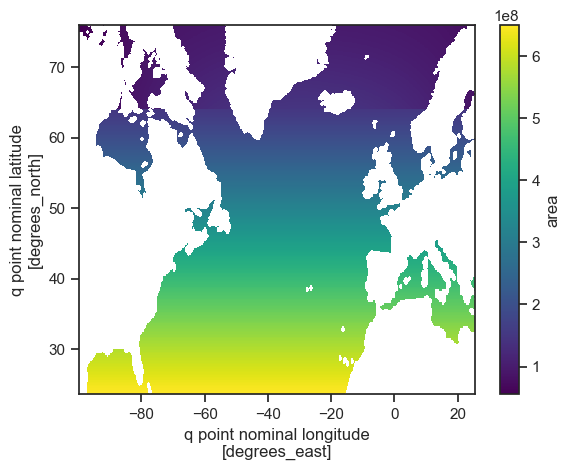

In [76]:
#ds_smooth['area'].plot()

tmp = ds_smooth['beta_V'].isel(filter_scale=0)
area = ds_smooth['area'].where((tmp > -1.e5) & ( tmp < 1.e5))

area.plot()

In [78]:
# Example for North Atlantic (30-70 N, Corre et al)
# Standard deviation in scales larger than filter scale

fldlist = ['beta_V', 'BPT','Curl_taus','Curl_taub','Curl_Adv','Curl_diff', 'Rest']

ds1 = ds_smooth.where((ds_smooth['geolon_c'] >= -80.) & (ds_smooth['geolon_c'] <= 0.) &
               (ds_smooth['geolat_c'] >= 30.) & (ds_smooth['geolat_c'] <= 70.)).compute()

tmp = ds1['beta_V'].isel(filter_scale=0)
area = ds_smooth['area'].where((tmp > -1.e5) & ( tmp < 1.e5))

ds_km_std = xr.Dataset()

for fld in fldlist:
    
    if (fld == 'Rest'):
        tmp1 = np.abs(ds1['Mass_flux'] + ds1['eta_dt'] + ds1['Curl_dudt'])
        tmp = (tmp1 * area).sum(['xq', 'yq']) / area.sum(['xq', 'yq'])
    else:
        tmp = (np.abs(ds1[fld]) * area).sum(['xq', 'yq']) / area.sum(['xq', 'yq'])
        
    ds_km_std[fld] = tmp

In [79]:
ds = ds_smooth.drop(['xq', 'yq']).assign_coords({'geolon_c': ds_smooth['geolon_c'], 
                                                 'geolat_c': ds_smooth['geolat_c']})
ds = ds.rename({'geolon_c':'longitude', 'geolat_c':'latitude'})

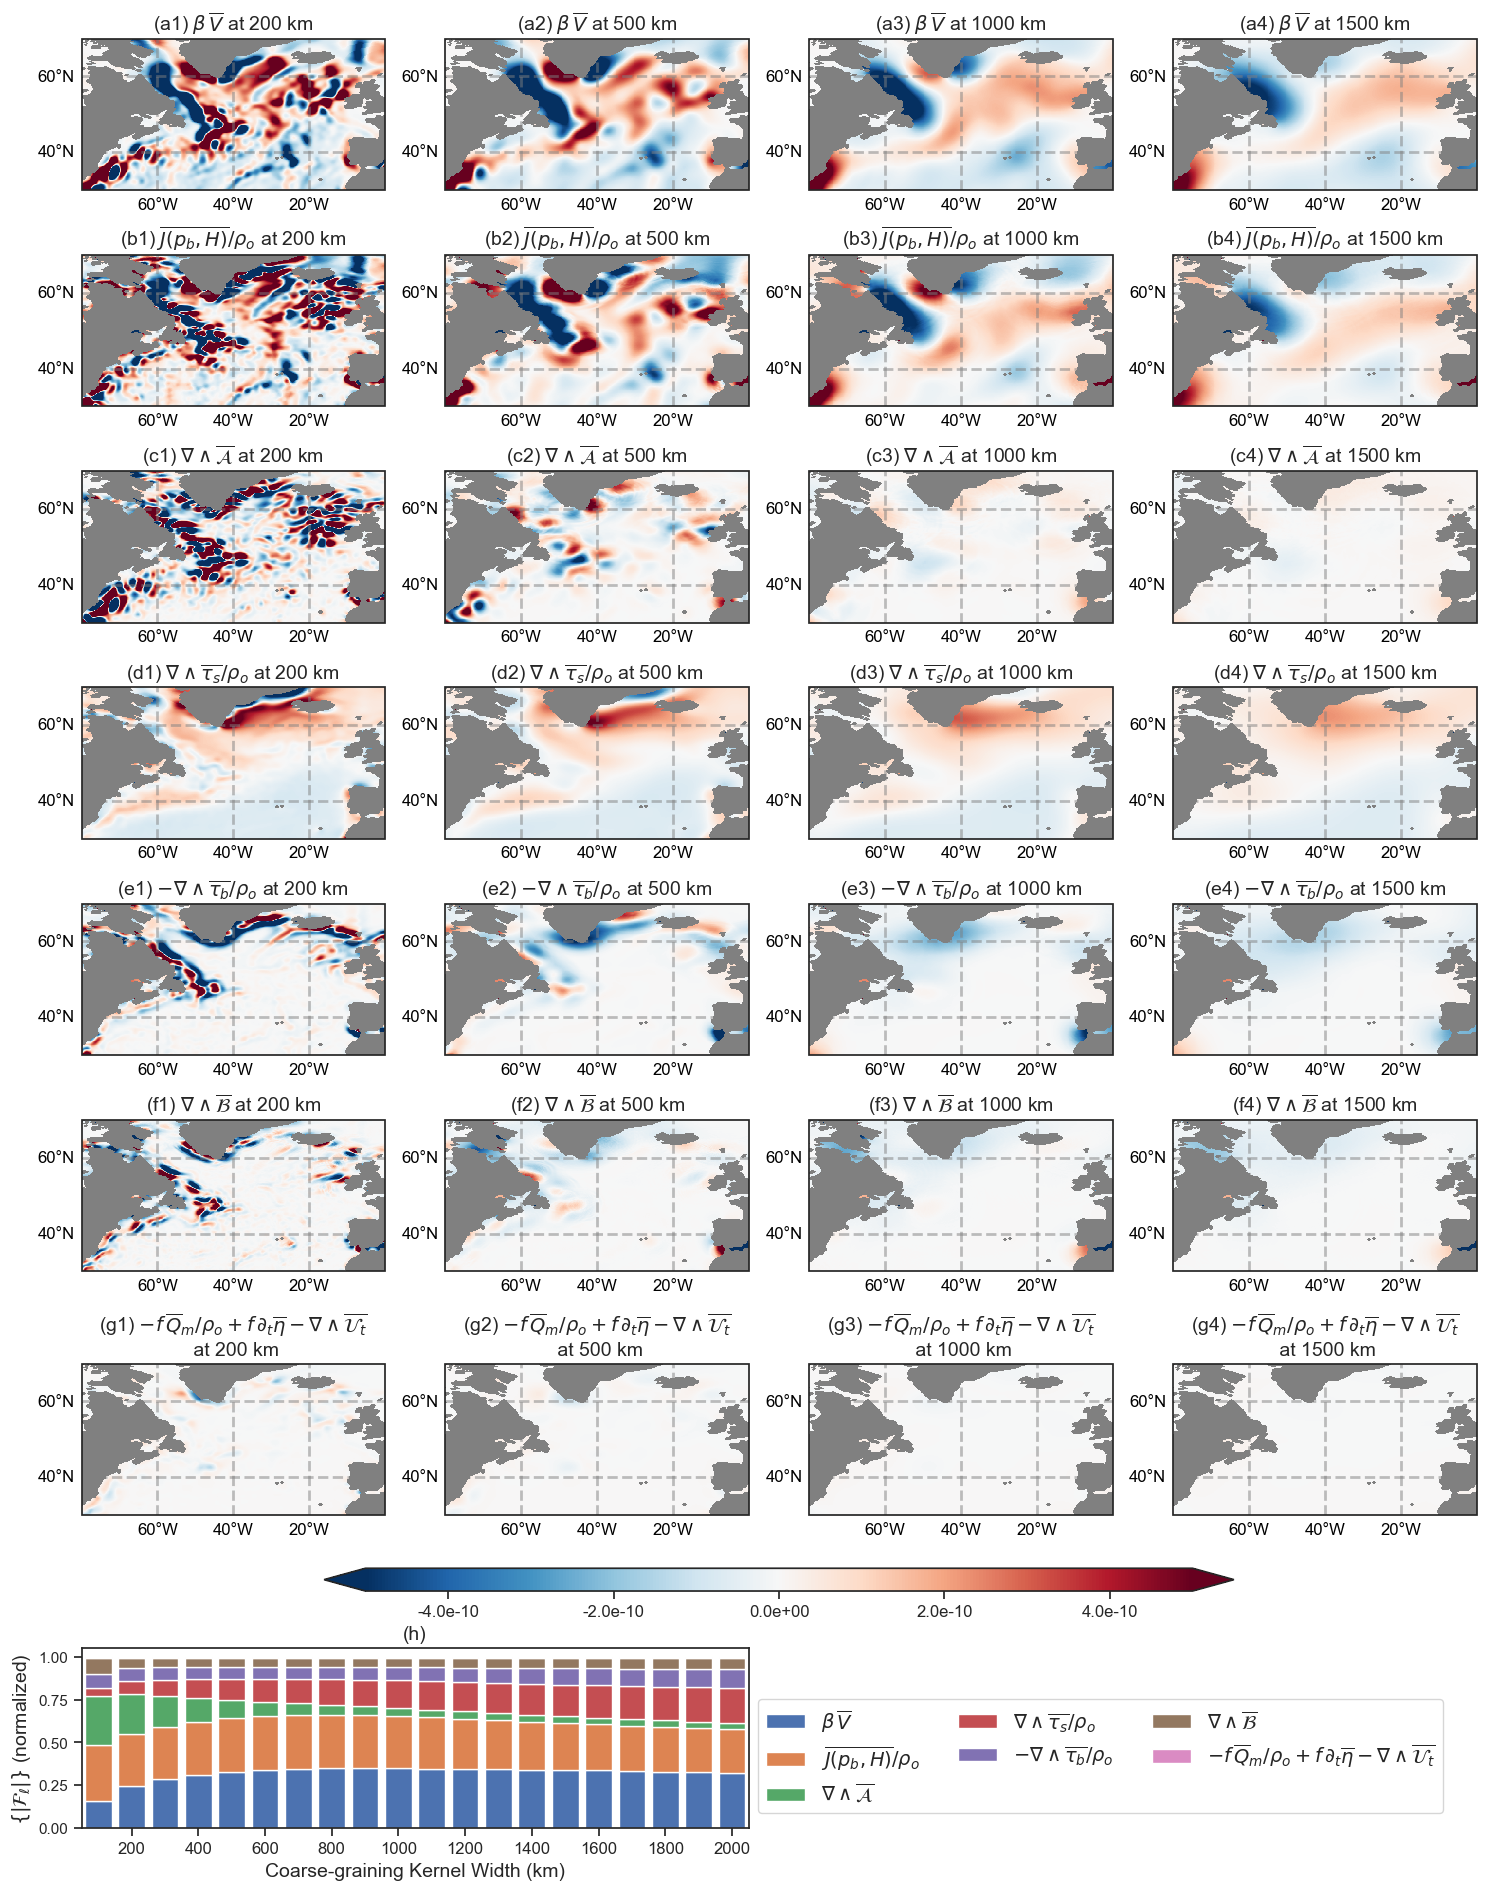

In [83]:
# Plot all terms for filtered in degree

lat_lon_ext = [-80., 0., 30., 70.]
max_r = 0.5e-9

grid1 = plt.GridSpec(8, 4, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,22])

ind = [1, 4, 9, 14] # 2, 5, 10 and 15 deg
j = 0

ax1 = [] 

for i in ind:
    
    ax = fig.add_subplot(grid1[0, j],projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['beta_V'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(97)+str(j+1) + ') ' + r'$\beta \, \overline{V}$ at ' + str((i+1)*100)+' km')
    if(j==0):
        plt.ylabel(r'$\beta \times V$', fontsize=14)
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[1, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['BPT'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(98)+str(j+1) + ') ' + r'$\overline{J(p_b, H)}/\rho_o$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[2, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_Adv'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(99)+str(j+1) + ') ' + r'$\nabla \wedge \overline{\mathcal{A}}$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[3, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_taus'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(100)+str(j+1) + ') ' + r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[4, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_taub'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(101)+str(j+1) + ') '  + r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[5, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, ds['Curl_diff'].isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(102)+str(j+1) + ') ' + r'$\nabla \wedge \overline{\mathcal{B}}$ at ' + str((i+1)*100)+' km')
    ax1.append(ax)
    
    ax = fig.add_subplot(grid1[6, j], projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, (ds['Mass_flux'] + ds['eta_dt'] + ds['Curl_dudt']).isel(filter_scale=i), vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='longitude', lat='latitude', cmap='RdBu_r', 
                 title='(' + chr(103)+str(j+1) + ') ' +
                 r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$'
                 + '\n at ' + str((i+1)*100)+' km')
    bbox=plt.gca().get_position()
    offset=.005
    plt.gca().set_position([bbox.x0, bbox.y0 - 2.5*offset, bbox.x1-bbox.x0 - 0.*offset, bbox.y1 - bbox.y0 + 0.0*offset])
    
    ax1.append(ax)
    
    j = j + 1
    
# $-f \times Q_m / \rho_o + f \partial_t\eta - \nabla \wedge \mathcal{U}_t$
#cb = fig.colorbar(p, ax=ax1, extend='both', orientation="horizontal", shrink=0.3)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax, width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(-2.8, -0.5, 3., 3.),
                   bbox_transform=ax.transAxes,
                   borderpad=0,)

cb = fig.colorbar(p, cax=axins, format='%.1e', extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

width = 0.8 
d = ds_km_std
scale = np.arange(d.filter_scale.shape[0]) + 1.0

ax = fig.add_subplot(grid1[7, 0:2])

bbox=plt.gca().get_position()
offset=.02
plt.gca().set_position([bbox.x0, bbox.y0 - 2.5*offset, bbox.x1-bbox.x0 - 0.*offset, bbox.y1 - bbox.y0 + 0.0*offset])
ax.set_xlim([0.5, 20.5])

bot = 0.
    
pos = - 0.0
width = 0.8

var_name = ['beta_V', 'BPT','Curl_Adv', 'Curl_taus', 'Curl_taub', 'Curl_diff', 'Rest']
norm_fac = d['beta_V'] + d['BPT'] + d['Curl_Adv'] + d['Curl_taus'] + d['Curl_taub'] + d['Curl_diff'] + d['Rest']

labels = [r'$\beta \, \overline{V}$', r'$\overline{J(p_b, H)}/\rho_o$', r'$\nabla \wedge \overline{\mathcal{A}}$',
          r'$\nabla \wedge\overline{{\tau_s}}/\rho_o$', r'$-\nabla \wedge\overline{{\tau_b}}/\rho_o$',
          r'$\nabla \wedge \overline{\mathcal{B}}$', 
         r'$-f \, \overline{Q}_m/{\rho_o}+f \, \partial_t\overline{\eta}-\nabla \wedge \overline{\mathcal{U}_t}$']

for var in var_name:
    
    tmp = d[var] / norm_fac
        
    plt.bar(scale + pos, tmp, width, bottom=bot)
        
    pos = pos + 0.*width
        
    bot = bot + tmp
    
ax.set_xlabel("Coarse-graining Kernel Width (km)", fontsize=14) 
ax.set_ylabel(r'$\{|\mathcal{F}_\ell|\}$ (normalized)', fontsize=14)
ax.set_title("(h)", fontsize=14)
plt.xticks(np.arange(2,21,2), np.arange(200, 2100, 200), fontsize=12);
#ax.legend(labels, loc='center left', bbox_to_anchor=(1.0, 0.0), fontsize=14)

ax.legend(labels, loc='center left', ncol=3,  bbox_to_anchor=(1.0, 0.4), fontsize=14)

fig.savefig('../../Plots/JAMES_Revision/North_Atlantic_Budget_gcm_filters.png',dpi=300,bbox_inches='tight');
